In [1]:
## Import all necessary packages

#To define and simulate the model
using DifferentialEquations

#To performe the global sensitivity analysis
using DiffEqSensitivity
using QuasiMonteCarlo

#To plot results
using PyPlot
using LaTeXStrings

In [2]:
# Model of differential equations compatible with DifferentialEquations.jl
function SEIR_v!(du, u, p, t)
    
    S, E, I, R, Sv, Iv = u #functions
    
    β, κ, γ, α, μ, N = p #parameters
    
    du[1] = dS = -β*S*Iv/N
    du[2] = dE = β*S*Iv/N - κ*E
    du[3] = dI = κ*E - γ*I
    du[4] = dR = γ*I
    
    du[5] = dSv = -α*Sv*I/N - μ*Sv
    du[6] = dIv = α*Sv*I/N - μ*Iv
    
end

SEIR_v! (generic function with 1 method)

In [3]:
#Select some reasonable initial values for the parameters
β = 0.019964629210535656
κ = (1/4.468534327936427) / 365
γ = (1/13.816202329656981) / (365)
α = 0.0864354643995437 
μ = 0.02209272187095225 

#Set the initial conditions
N = 19417*81
Nv = 19417*81 * 0.5

E0 = 0
I0 = 0.01 * N
S0 = N - I0
R0 = 0

Sv0 = Nv
Iv0 = 0

#Set the simulation time
N_years = 50

t = 365 * N_years

#Define the model in DifferentialEquations.jl
initial_conditions = [S0, E0, I0, R0, Sv0, Iv0]

parameters = [β, κ, γ, α, μ, N]

time = (0.0, t)

dosetimes = [365.0 * i for i in 1 : N_years]

affect!(integrator) = integrator.u[5] = Nv

cb = PresetTimeCallback(dosetimes, affect!)

prob = ODEProblem(SEIR_v!, initial_conditions, time, parameters)

#Define the function to perform the global sensitivity analysis
f1 = function (p)
    
  prob1 = remake(prob; p=p)
    
  sol = solve(prob1, RK4(), dt=0.001)
    
  [sol.t[argmax(sol[2,:])], maximum(sol[2,:]), sol[3, end]]
    
end

#3 (generic function with 1 method)

In [4]:
#Number of MC realisations
N = 10^4

#Lower and upper bounds for the parameters in the MC exploration
lb = [1e-3, 1/3, 1/5, 1e-3, 0.01, 1e6]
ub = [1e-1, 1/7, 1/25, 1, 0.04, 1e6]

#Use the Sobol sampler
sampler = SobolSample()

#Create the MC matrices
A,B = QuasiMonteCarlo.generate_design_matrices(N, lb, ub, sampler)

#Perform the global sensitivity analysis with the Sobol method
sobol_result = @time gsa(f1, Sobol(order=[0, 1, 2]), A, B);

┌ Warning: Global Sensitivity Analysis has been moved to separate package GlobalSensitivity.jl (https://github.com/SciML/GlobalSensitivity.jl)
└ @ DiffEqSensitivity /home/alex/.julia/packages/DiffEqSensitivity/5hKQk/src/DiffEqSensitivity.jl:74


183.307595 seconds (947.85 M allocations: 122.635 GiB, 8.19% gc time, 11.13% compilation time)


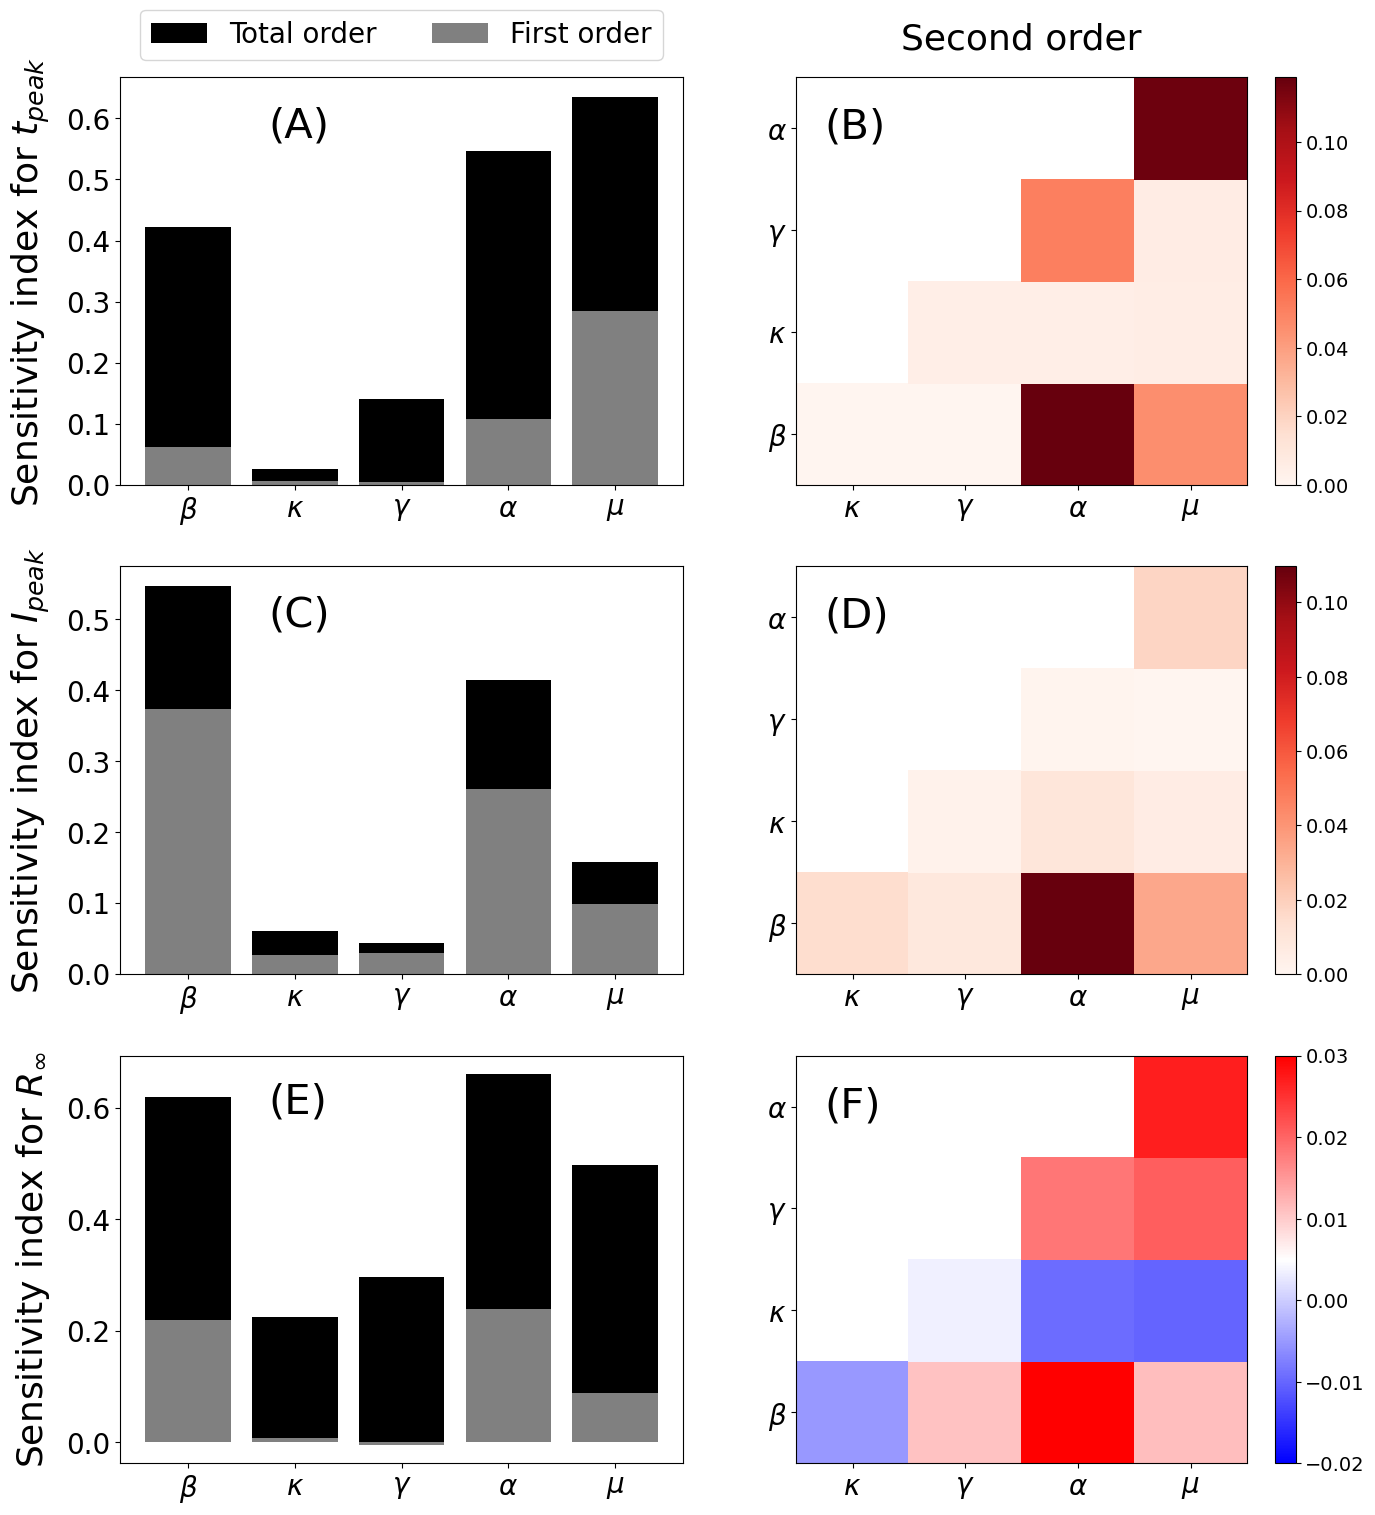

In [5]:
#Plot the results

xlabels = [L"\beta", L"\kappa", L"\gamma", L"\alpha", L"\mu", "N"]

fig, ax = plt.subplot_mosaic("AB
    CD
    EF", figsize=(8*2, 6*3))

## Peak time
total_order_indices_t = sobol_result.ST[1, :]
first_order_indices_t = sobol_result.S1[1, :]
second_order_indices_t = sobol_result.S2[:, :, 1]

second_order_indices_t[second_order_indices_t .== 0.0] .= NaN

ax["A"].bar(xlabels[1:end-1], total_order_indices_t[1:end-1], color="k", label="Total order")
ax["A"].bar(xlabels[1:end-1], first_order_indices_t[1:end-1], color="gray", label="First order")

ax["A"].text(0.75, 0.57, "(A)", fontsize=30)

ax["A"].tick_params(labelsize=20)
ax["A"].legend(ncol=2, fontsize=20, loc="upper center", bbox_to_anchor=(0.5, 1.2))

ax["A"].set_ylabel(L"Sensitivity index for $t_{peak}$", fontsize=26, labelpad=10)

cnplot = ax["B"].pcolormesh(second_order_indices_t[1:4, 2:5], cmap="Reds", vmin=0)

ax["B"].text(0.25, 3.4, "(B)", fontsize=30)

ax["B"].set_xticks(0.5:1:4)
ax["B"].set_xticklabels(xlabels[2:end-1], fontsize=20)

ax["B"].set_yticks(0.5:1:4)
ax["B"].set_yticklabels(xlabels[1:end-2], fontsize=20)

ax["B"].set_title("Second order", fontsize=26, pad=20)

cbar = plt.colorbar(cnplot, ax=ax["B"])

cbar.ax.tick_params(labelsize=14)

## Peak magnitude
total_order_indices_t = sobol_result.ST[2, :]
first_order_indices_t = sobol_result.S1[2, :]
second_order_indices_t = sobol_result.S2[:, :, 2]

second_order_indices_t[second_order_indices_t .== 0.0] .= NaN

ax["C"].bar(xlabels[1:end-1], total_order_indices_t[1:end-1], color="k", label="Total order")
ax["C"].bar(xlabels[1:end-1], first_order_indices_t[1:end-1], color="gray", label="First order")

ax["C"].text(0.75, 0.49, "(C)", fontsize=30)

ax["C"].tick_params(labelsize=20)

ax["C"].set_ylabel(L"Sensitivity index for $I_{peak}$", fontsize=26, labelpad=10)

cnplot = ax["D"].pcolormesh(second_order_indices_t[1:4, 2:5], cmap="Reds", vmin=0)

ax["D"].text(0.25, 3.4, "(D)", fontsize=30)

ax["D"].set_xticks(0.5:1:4)
ax["D"].set_xticklabels(xlabels[2:end-1], fontsize=20)

ax["D"].set_yticks(0.5:1:4)
ax["D"].set_yticklabels(xlabels[1:end-2], fontsize=20)

cbar = plt.colorbar(cnplot, ax=ax["D"])

cbar.ax.tick_params(labelsize=14)

## R_inf
total_order_indices_t = sobol_result.ST[3, :]
first_order_indices_t = sobol_result.S1[3, :]
second_order_indices_t = sobol_result.S2[:, :, 3]

second_order_indices_t[second_order_indices_t .== 0.0] .= NaN

ax["E"].bar(xlabels[1:end-1], total_order_indices_t[1:end-1], color="k", label="Total order")
ax["E"].bar(xlabels[1:end-1], first_order_indices_t[1:end-1], color="gray", label="First order")

ax["E"].text(0.75, 0.59, "(E)", fontsize=30)

ax["E"].tick_params(labelsize=20)

ax["E"].set_ylabel(L"Sensitivity index for $R_{\infty}$", fontsize=26, labelpad=10)

cnplot = ax["F"].pcolormesh(second_order_indices_t[1:4, 2:5], cmap="bwr", vmax=0.03, vmin=-0.02)

ax["F"].text(0.25, 3.4, "(F)", fontsize=30)

ax["F"].set_xticks(0.5:1:4)
ax["F"].set_xticklabels(xlabels[2:end-1], fontsize=20)

ax["F"].set_yticks(0.5:1:4)
ax["F"].set_yticklabels(xlabels[1:end-2], fontsize=20)

cbar = plt.colorbar(cnplot, ax=ax["F"])

cbar.ax.tick_params(labelsize=14)